# Tikhonov Algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import pinv, inv
from sklearn.linear_model import Lasso
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
print("Loading data files...")

# Load the Excel files, skipping first row and first column (labels)
S_true = pd.read_excel('Source.xlsx', header=None).iloc[1:, 1:].astype(float).values  # 16 x 1000
G = pd.read_excel('Leadfield.xlsx', header=None).iloc[1:, 1:].astype(float).values     # 32 x 16
Y = pd.read_excel('EEG Data.xlsx', header=None).iloc[1:, 1:].astype(float).values      # 32 x 1000
N = pd.read_excel('Noise.xlsx', header=None).iloc[1:, 1:].astype(float).values         # 32 x 1000

print(f"Source shape: {S_true.shape}")
print(f"Leadfield shape: {G.shape}")
print(f"EEG Data shape: {Y.shape}")
print(f"Noise shape: {N.shape}")

Loading data files...
Source shape: (16, 1000)
Leadfield shape: (32, 16)
EEG Data shape: (32, 1000)
Noise shape: (32, 1000)


In [ ]:
def solve_Tikhonov(G, Y, reg_param=0.01):
    """
    Tikhonov Regularization (Ridge Regression)
    S = (G^T G + λI)^-1 G^T Y
    """
    n_sources = G.shape[1]
    I = np.eye(n_sources)
    GTG = G.T @ G
    lambda_I = reg_param * I
    S_est = inv(GTG + lambda_I) @ G.T @ Y # @: matrix multiplication operator
    return S_est

In [4]:
METHODS = {
    'Tikhonov': lambda G, Y: solve_Tikhonov(G, Y, reg_param=0.01),
    }

In [6]:
def calculate_accuracy(S_true, S_est):
    """
    Calculate reconstruction accuracy using Normalized Mean Squared Error
    Accuracy = (1 - sqrt(NMSE)) * 100%
    """
    mse = np.mean((S_true - S_est)**2)
    signal_power = np.mean(S_true**2)
    nmse = mse / signal_power
    accuracy = (1 - np.sqrt(nmse)) * 100
    return max(0, min(100, accuracy))


def calculate_correlation(S_true, S_est):
    """
    Calculate correlation coefficient for each source
    Returns array of correlations and average
    """
    n_sources = S_true.shape[0]
    correlations = []
    
    for i in range(n_sources):
        corr = np.corrcoef(S_true[i, :], S_est[i, :])[0, 1]
        correlations.append(corr)
    
    return np.array(correlations), np.mean(correlations)


def calculate_relative_error(S_true, S_est):
    """
    Calculate relative error (%)
    """
    rel_error = np.linalg.norm(S_true - S_est) / np.linalg.norm(S_true) * 100
    return rel_error

In [ ]:
SELECTED_METHODS = ['Tikhonov'] 

# Store results
results = {}


Y_clean = Y.copy()

print(f"\nRunning {method_name} without noise...")

# Solve inverse problem
S_est = METHODS[method_name](G, Y_clean)

# Calculate metrics
accuracy = calculate_accuracy(S_true, S_est)
correlations, avg_corr = calculate_correlation(S_true, S_est)
rel_error = calculate_relative_error(S_true, S_est)

# Store results
results[f"{method_name}_clean"] = {
    'S_est': S_est,
    'accuracy': accuracy,
    'correlations': correlations,
    'avg_correlation': avg_corr,
    'relative_error': rel_error
}

print(f"  Accuracy: {accuracy:.2f}%")
print(f"  Average Correlation: {avg_corr:.4f}")
print(f"  Relative Error: {rel_error:.2f}%")


Running Tikhonov without noise...
  Accuracy: 90.88%
  Average Correlation: 0.8715
  Relative Error: 9.12%


# Tikhonov with Noisy Data

In [12]:
Y_noisy = Y + N

for method_name in SELECTED_METHODS:
    print(f"\nRunning {method_name} with noise...")
    
    # Solve inverse problem
    S_est = METHODS[method_name](G, Y_noisy)
    
    # Calculate metrics
    accuracy = calculate_accuracy(S_true, S_est)
    correlations, avg_corr = calculate_correlation(S_true, S_est)
    rel_error = calculate_relative_error(S_true, S_est)
    
    # Store results
    results[f"{method_name}_noisy"] = {
        'S_est': S_est,
        'accuracy': accuracy,
        'correlations': correlations,
        'avg_correlation': avg_corr,
        'relative_error': rel_error
    }
    
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Average Correlation: {avg_corr:.4f}")
    print(f"  Relative Error: {rel_error:.2f}%")


Running Tikhonov with noise...
  Accuracy: 82.08%
  Average Correlation: 0.6907
  Relative Error: 17.92%


# Comparisons and Visualizations

In [13]:
summary_data = []
for key, result in results.items():
    method_name = key.rsplit('_', 1)[0]
    condition = 'Clean' if 'clean' in key else 'Noisy'
    summary_data.append({
        'Method': method_name,
        'Condition': condition,
        'Accuracy (%)': f"{result['accuracy']:.2f}",
        'Avg Correlation': f"{result['avg_correlation']:.4f}",
        'Relative Error (%)': f"{result['relative_error']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

  Method Condition Accuracy (%) Avg Correlation Relative Error (%)
Tikhonov     Clean        90.88          0.8715               9.12
Tikhonov     Noisy        82.08          0.6907              17.92


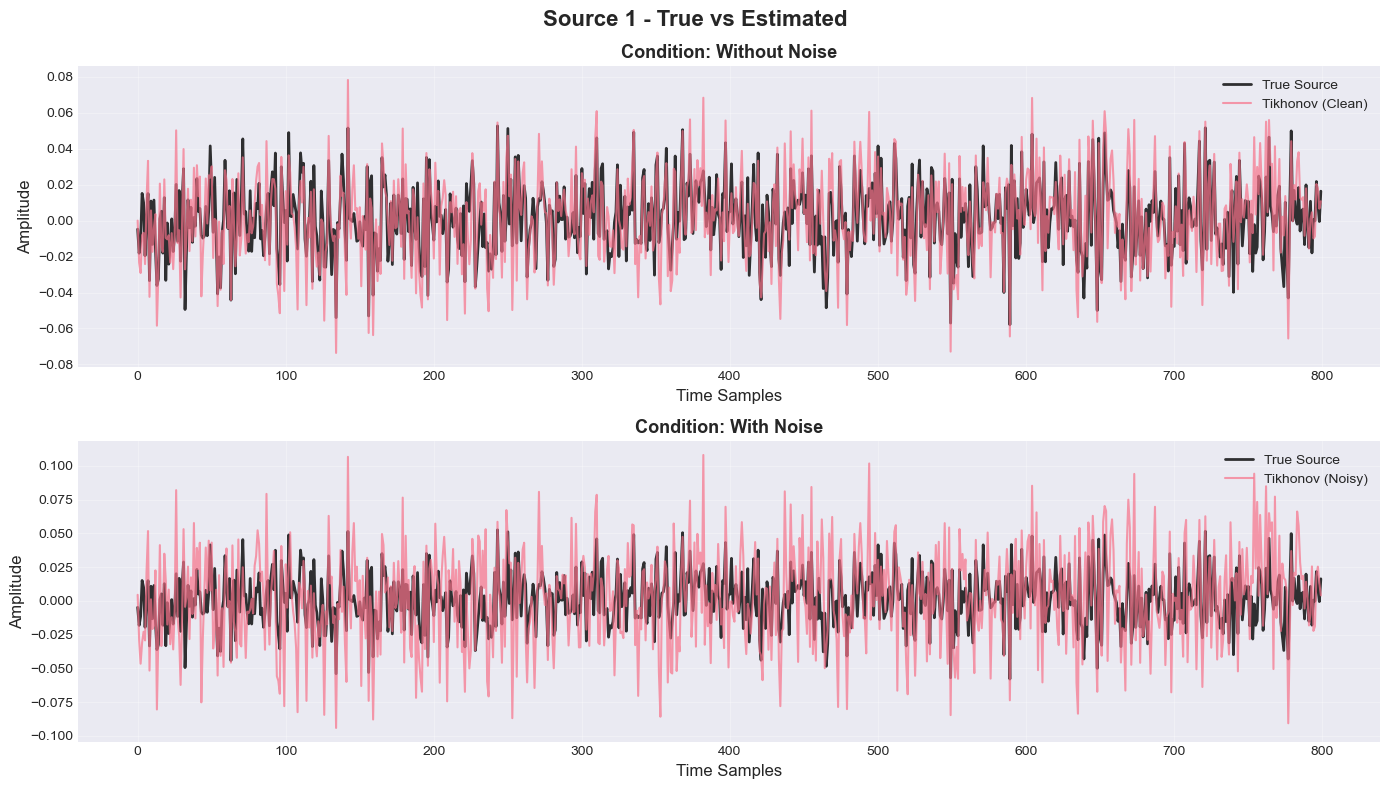

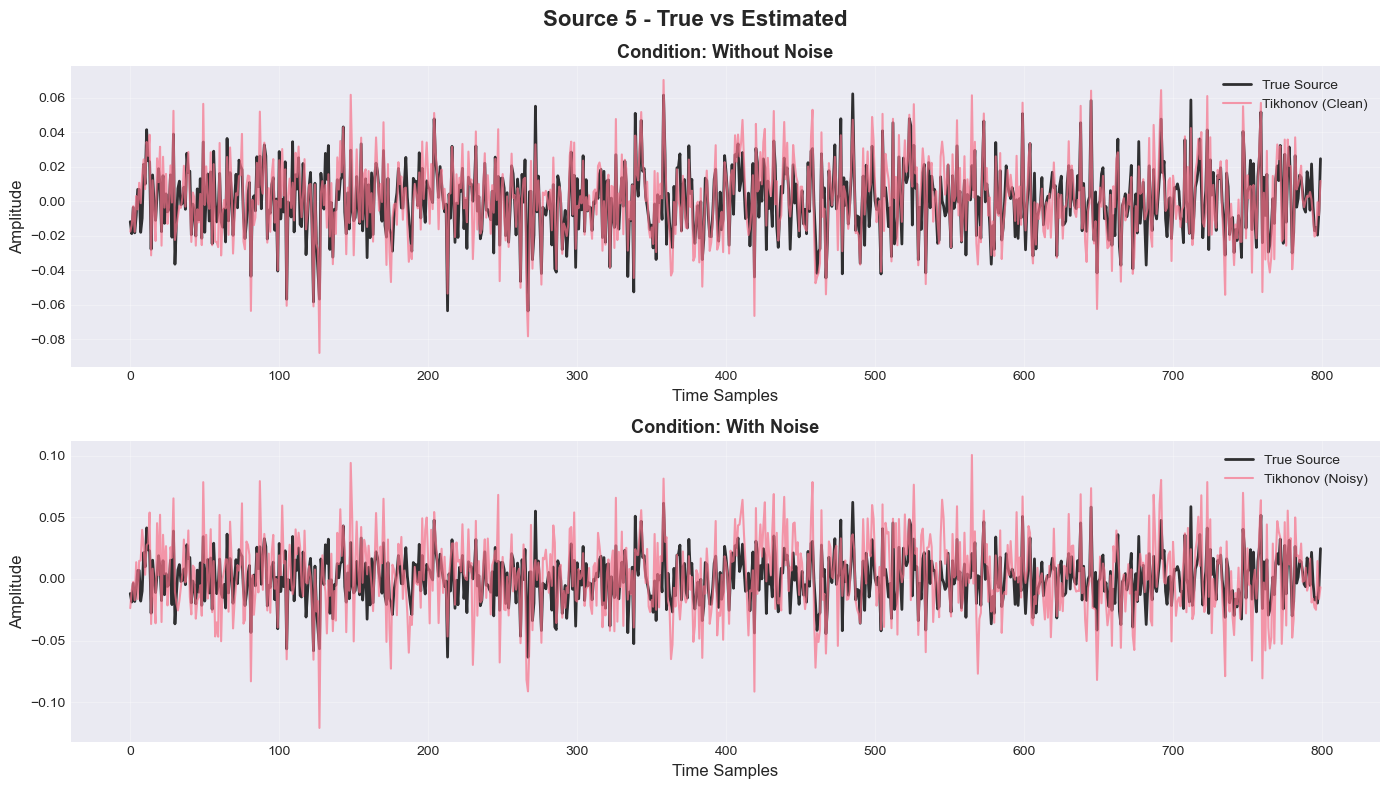

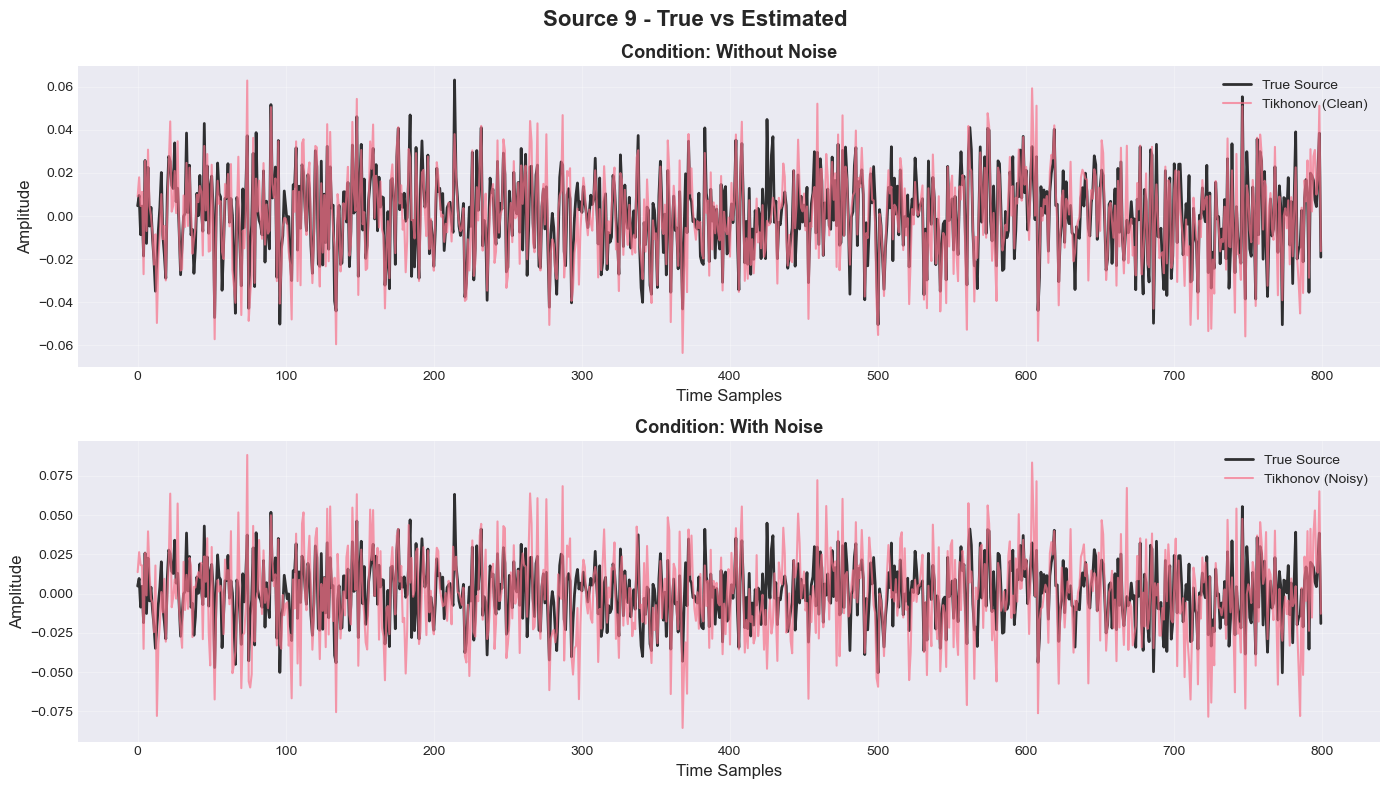

In [14]:
sources_to_plot = [0, 4, 8]  # 0-indexed (Source 1, 5, 9)
time_samples = 800  # Number of time samples to plot

for source_idx in sources_to_plot:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    fig.suptitle(f'Source {source_idx + 1} - True vs Estimated', 
                 fontsize=16, fontweight='bold')
    
    time = np.arange(time_samples)
    
    # Plot 1: Without Noise
    ax = axes[0]
    ax.plot(time, S_true[source_idx, :time_samples], 
            'k-', linewidth=2, label='True Source', alpha=0.8)
    
    for method_name in SELECTED_METHODS:
        S_est = results[f"{method_name}_clean"]['S_est']
        ax.plot(time, S_est[source_idx, :time_samples], 
                linewidth=1.5, label=f'{method_name} (Clean)', alpha=0.7)
    
    ax.set_xlabel('Time Samples', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title('Condition: Without Noise', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: With Noise
    ax = axes[1]
    ax.plot(time, S_true[source_idx, :time_samples], 
            'k-', linewidth=2, label='True Source', alpha=0.8)
    
    for method_name in SELECTED_METHODS:
        S_est = results[f"{method_name}_noisy"]['S_est']
        ax.plot(time, S_est[source_idx, :time_samples], 
                linewidth=1.5, label=f'{method_name} (Noisy)', alpha=0.7)
    
    ax.set_xlabel('Time Samples', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title('Condition: With Noise', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'source_{source_idx + 1}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



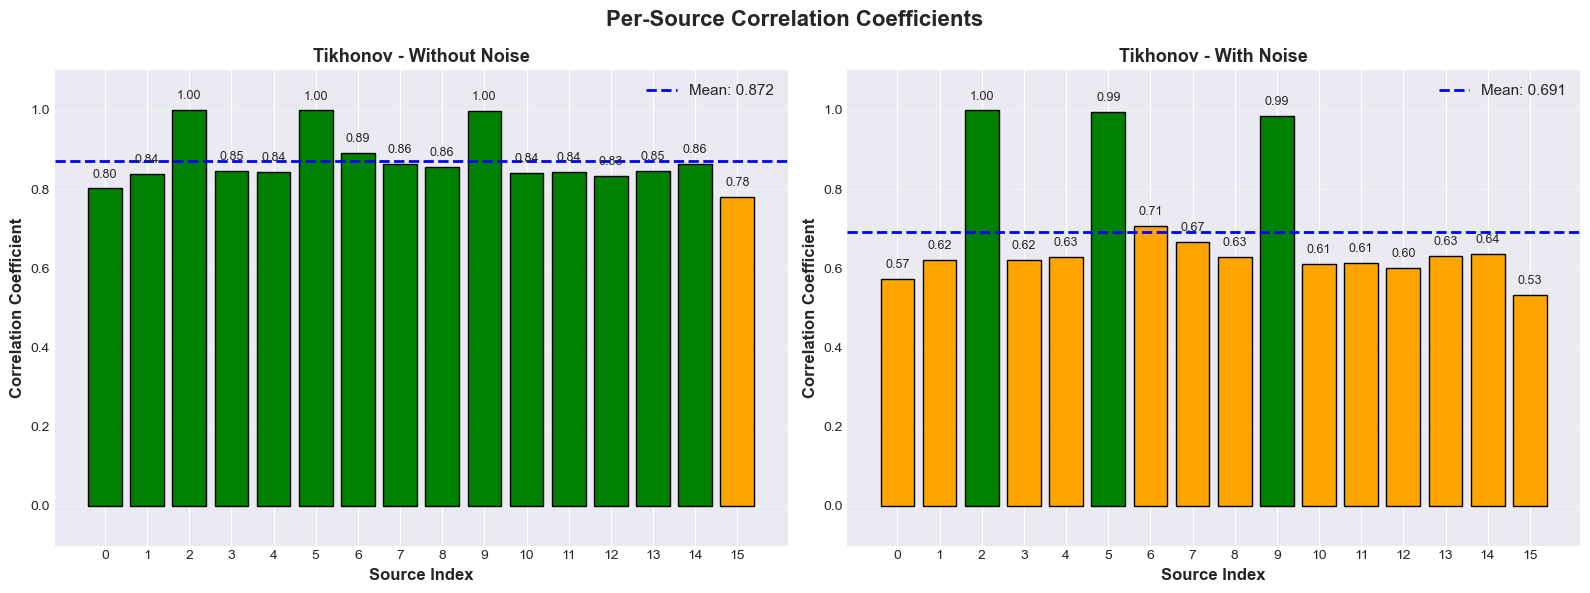

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Per-Source Correlation Coefficients', fontsize=16, fontweight='bold')

source_indices = np.arange(S_true.shape[0])

for method_name in SELECTED_METHODS:
    # Get correlations for both conditions
    clean_corr = np.nan_to_num(results[f"{method_name}_clean"]['correlations'], nan=0.0)
    noisy_corr = np.nan_to_num(results[f"{method_name}_noisy"]['correlations'], nan=0.0)
    
    # Plot 1: Without Noise
    ax = axes[0]
    colors_clean = ['green' if c > 0.8 else 'orange' if c > 0.5 else 'red' for c in clean_corr]
    bars1 = ax.bar(source_indices, clean_corr, color=colors_clean, edgecolor='black', linewidth=1)
    ax.axhline(y=np.mean(clean_corr), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(clean_corr):.3f}')
    ax.set_xlabel('Source Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax.set_title(f'{method_name} - Without Noise', fontsize=13, fontweight='bold')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks(source_indices)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=11)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, clean_corr)):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: With Noise
    ax = axes[1]
    colors_noisy = ['green' if c > 0.8 else 'orange' if c > 0.5 else 'red' for c in noisy_corr]
    bars2 = ax.bar(source_indices, noisy_corr, color=colors_noisy, edgecolor='black', linewidth=1)
    ax.axhline(y=np.mean(noisy_corr), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(noisy_corr):.3f}')
    ax.set_xlabel('Source Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax.set_title(f'{method_name} - With Noise', fontsize=13, fontweight='bold')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks(source_indices)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(fontsize=11)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars2, noisy_corr)):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('correlation_per_source.png', dpi=300, bbox_inches='tight')
plt.show()

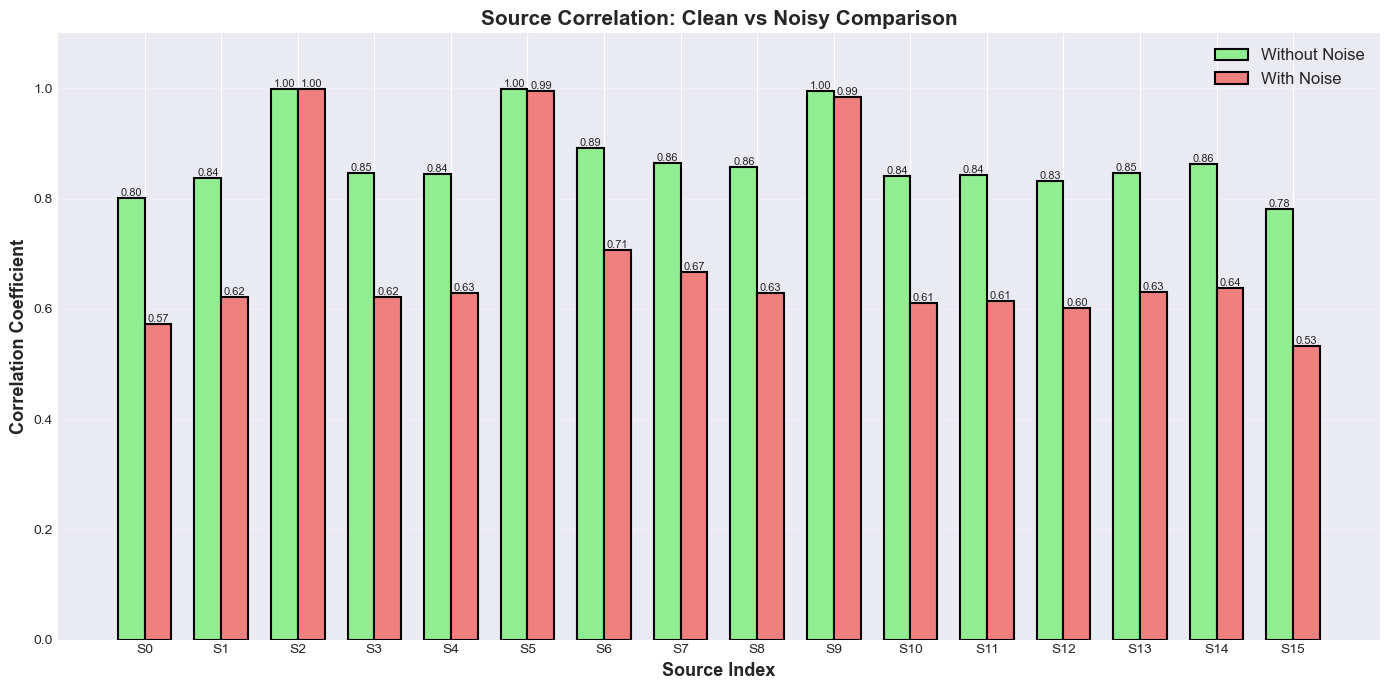

In [16]:
fig, ax = plt.subplots(figsize=(14, 7))

for method_name in SELECTED_METHODS:
    clean_corr = np.nan_to_num(results[f"{method_name}_clean"]['correlations'], nan=0.0)
    noisy_corr = np.nan_to_num(results[f"{method_name}_noisy"]['correlations'], nan=0.0)
    
    x = np.arange(len(clean_corr))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, clean_corr, width, label='Without Noise', 
                   color='lightgreen', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, noisy_corr, width, label='With Noise', 
                   color='lightcoral', edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Source Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Correlation Coefficient', fontsize=13, fontweight='bold')
ax.set_title('Source Correlation: Clean vs Noisy Comparison', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'S{i}' for i in range(len(clean_corr))])
ax.set_ylim([0, 1.1])
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_comparison_clean_vs_noisy.png', dpi=300, bbox_inches='tight')
plt.show()

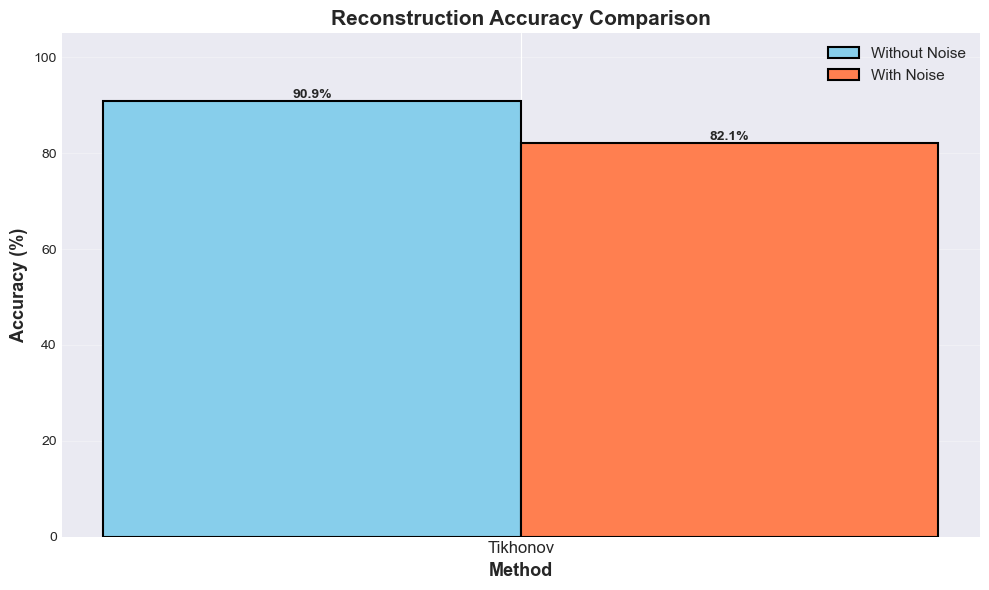

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

methods = SELECTED_METHODS
conditions = ['Clean', 'Noisy']
x = np.arange(len(methods))
width = 0.35

clean_accuracies = [results[f"{m}_clean"]['accuracy'] for m in methods]
noisy_accuracies = [results[f"{m}_noisy"]['accuracy'] for m in methods]

bars1 = ax.bar(x - width/2, clean_accuracies, width, label='Without Noise', 
               color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, noisy_accuracies, width, label='With Noise', 
               color='coral', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Method', fontsize=13, fontweight='bold')
ax.set_title('Reconstruction Accuracy Comparison', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=12)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()